# WormLib: open source image analysis library for *C. elegans* 

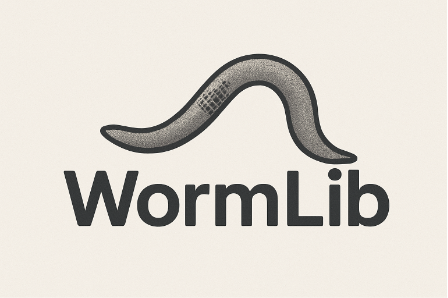

Welcome to WormLib v. 1.0.0


In [1]:
# #Import packages
import bigfish
import bigfish.stack as stack
import bigfish.plot as plot
import bigfish.multistack as multistack
import bigfish.detection as detection
import cellpose
from cellpose import models, utils
import cv2
import csv
from datetime import datetime
from IPython.display import display
import joblib  # for saving/loading models
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing as mp
import nd2
import numpy as np
import os
import pandas as pd
from PIL import Image
import plotly.graph_objects as go
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch
from reportlab.platypus import Table, TableStyle, SimpleDocTemplate
from scipy.ndimage import binary_dilation, label, gaussian_filter, rotate, center_of_mass, zoom
from scipy.spatial import cKDTree
import seaborn as sns
import skimage
from skimage import measure, morphology, filters
from skimage.draw import polygon2mask
from skimage.measure import label, regionprops
from skimage.measure import regionprops_table
from skimage.morphology import square, dilation,erosion, disk, binary_erosion
from skimage import measure, morphology
from skimage.morphology import disk, binary_erosion
from skimage.transform import resize
from skimage.util import img_as_float
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import InconsistentVersionWarning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tifffile
import tifffile as tiff
import time
import warnings
from IPython.display import Image, display

  
logo_path = "/projects/naly@colostate.edu/ce-bigfish/01_notebooks/WormLib_logo.png"
display(Image(filename=logo_path))
print("Welcome to WormLib v. 1.0.0")



## 1. Specify input

#### 1.1 Input (use if running as array with bash script; comment otherwise)

In [2]:
# #Specify parameters here if running with sbatch script
import os

# # 1. Define image path, microscope parameters and channel names (set to None if the channel does not exist)
# folder_name = os.getenv('FOLDER_NAME')
# output_directory = os.getenv('OUTPUT_DIRECTORY')

# # PSF parameters
# psf_calculator = os.getenv('PSF_CALCULATOR', 'False') == 'False'
# spot_radius_ch0 = tuple(map(int, os.getenv('SPOT_RADIUS_CH0', '1409,340,340').split(',')))
# spot_radius_ch1 = tuple(map(int, os.getenv('SPOT_RADIUS_CH1', '1283,310,310').split(',')))
# voxel_size = tuple(map(int, os.getenv('VOXEL_SIZE', '1448,450,450').split(',')))

# # Channels
# Cy5 = os.getenv('Cy5')
# mCherry = os.getenv('mCherry')
# FITC = os.getenv('FITC')
# DAPI = os.getenv('DAPI')
# brightfield = os.getenv('brightfield')

# # 2. Select image type
# dv_images = os.getenv('DV_IMAGES', 'True') == 'True'
# nd2_images = os.getenv('ND2_IMAGES', 'False') == 'True'
# tiff_images = os.getenv('TIFF_IMAGES', 'False') == 'True'

# # 3. Segmentation
# run_embryo_segmentation = os.getenv('RUN_EMBRYO_SEGMENTATION', 'True') == 'True'
# embryo_diameter = int(os.getenv('EMBRYO_DIAMETER', '500'))
# nuclei_diameter = int(os.getenv('NUCLEI_DIAMETER', '70'))
# run_cell_segmentation = os.getenv('RUN_CELL_SEGMENTATION', 'True') == 'True'
# cell_diameter = int(os.getenv('CELL_DIAMETER', '250'))
# run_cell_classifier = os.getenv('RUN_CELL_CLASSIFIER', 'True') == 'True'

# # 4. Spot detection
# run_spot_detection = os.getenv('RUN_SPOT_DETECTION', 'True') == 'True'

# # 5. Spatial mRNA analysis
# run_mRNA_heatmaps = os.getenv('RUN_mRNA_HEATMAPS', 'True') == 'True'
# run_rna_density_analysis = os.getenv('RUN_RNA_DENSITY_ANALYSIS', 'True') == 'True'
# run_line_scan_analysis = os.getenv('RUN_LINE_SCAN_ANALYSIS', 'True') == 'True'


# # Ensure required parameters are set
# if folder_name is None or output_directory is None:
#     raise ValueError("Both 'FOLDER_NAME' and 'OUTPUT_DIRECTORY' must be provided.")

# # # Print parameters to verify
# print(f"Input directory: {folder_name}")
# print(f"Output directory: {output_directory}")

# # Image types
# if dv_images: print("Image type: DV")
# if nd2_images: print("Image type: ND2")
# if tiff_images: print("Image type: TIFF")

# # Channels (always show them, or add conditions if needed)
# print(f"\nChannels:")
# if Cy5: print(f"  Cy5 = {Cy5}")
# if mCherry: print(f"  mCherry = {mCherry}")
# if FITC and FITC != "nothing": print(f"  FITC = {FITC}")
# if DAPI: print(f"  DAPI = {DAPI}")
# if brightfield: print(f"  Brightfield = {brightfield}")

# # PSF parameters
# print(f"\nPSF Parameters:")
# print(f"  Spot Radius Ch0 = {spot_radius_ch0}")
# print(f"  Spot Radius Ch1 = {spot_radius_ch1}")
# print(f"  Voxel Size = {voxel_size}")

# # Segmentation
# print(f"\nEnabled Features:")
# if run_embryo_segmentation: print(f"  Embryo segmentation with diameter {embryo_diameter} ")
# if run_cell_segmentation: print("  Cell segmentation")

# # Spot detection
# if run_spot_detection: print("  Spot detection")

# # 5. Spatial analysis
# if run_mRNA_heatmaps: print("  mRNA heatmaps")
# if run_rna_density_analysis: print("  RNA density analysis")
# if run_line_scan_analysis: print(" Line scan analysis")
# print()


#### 1.2 Input (use if running as jupyter notebook; comment otherwise)

In [3]:
# #Specify parameters here if running as jupyter notebook

# 1. Define image path, microscope parameters and channel names (set to None if the channel does not exist)
folder_name = '../240812_N2_erm-1_set-3/2-cell/input/08' #image subdirectory path

voxel_size = (1448, 450, 450)   # Microscope pixel size in nm (Z,Y,X)
spot_radius_ch0 = (1409, 340, 340)  # PSF Z,Y,X #Settings used for mCherry channel
spot_radius_ch1 = (1283, 310, 310)  # PSF Z,Y,X #Settings used for Cy5 channel

Cy5 = "mRNA1"  # (Q670)
mCherry = "mRNA2"  # (Q610)
FITC = "nothing"  # (GFP)
DAPI = "DAPI"
brightfield = "brightfield"

# 2. Select image type
dv_images = True
nd2_images = False
tiff_images = False

# 3. Segmentation
run_embryo_segmentation = True
embryo_diameter = 500
nuclei_diameter = 70
run_cell_segmentation = True
cell_diameter = 250
run_cell_classifier = True

# 4. Spot detection
run_spot_detection = True

# 5. Spatial analysis of mRNA
run_mRNA_heatmaps = True
run_rna_density_analysis = True
run_line_scan_analysis = True


#Specify where the data will be stored
output_directory = os.path.join(os.path.dirname(os.path.dirname(folder_name)), "output", os.path.basename(folder_name))
os.makedirs(output_directory, exist_ok=True)


## 2. Load image(s)

#### 2.1 Deltavision files

Image ID: 240812_N2_erm-1_set-3_08 

Image colors 
240812_N2_erm-1_set-3_08_R3D.dv: (4, 56, 1024, 1024) 

Brightfield 
240812_N2_erm-1_set-3_08_R3D_REF.dv: (1024, 1024)


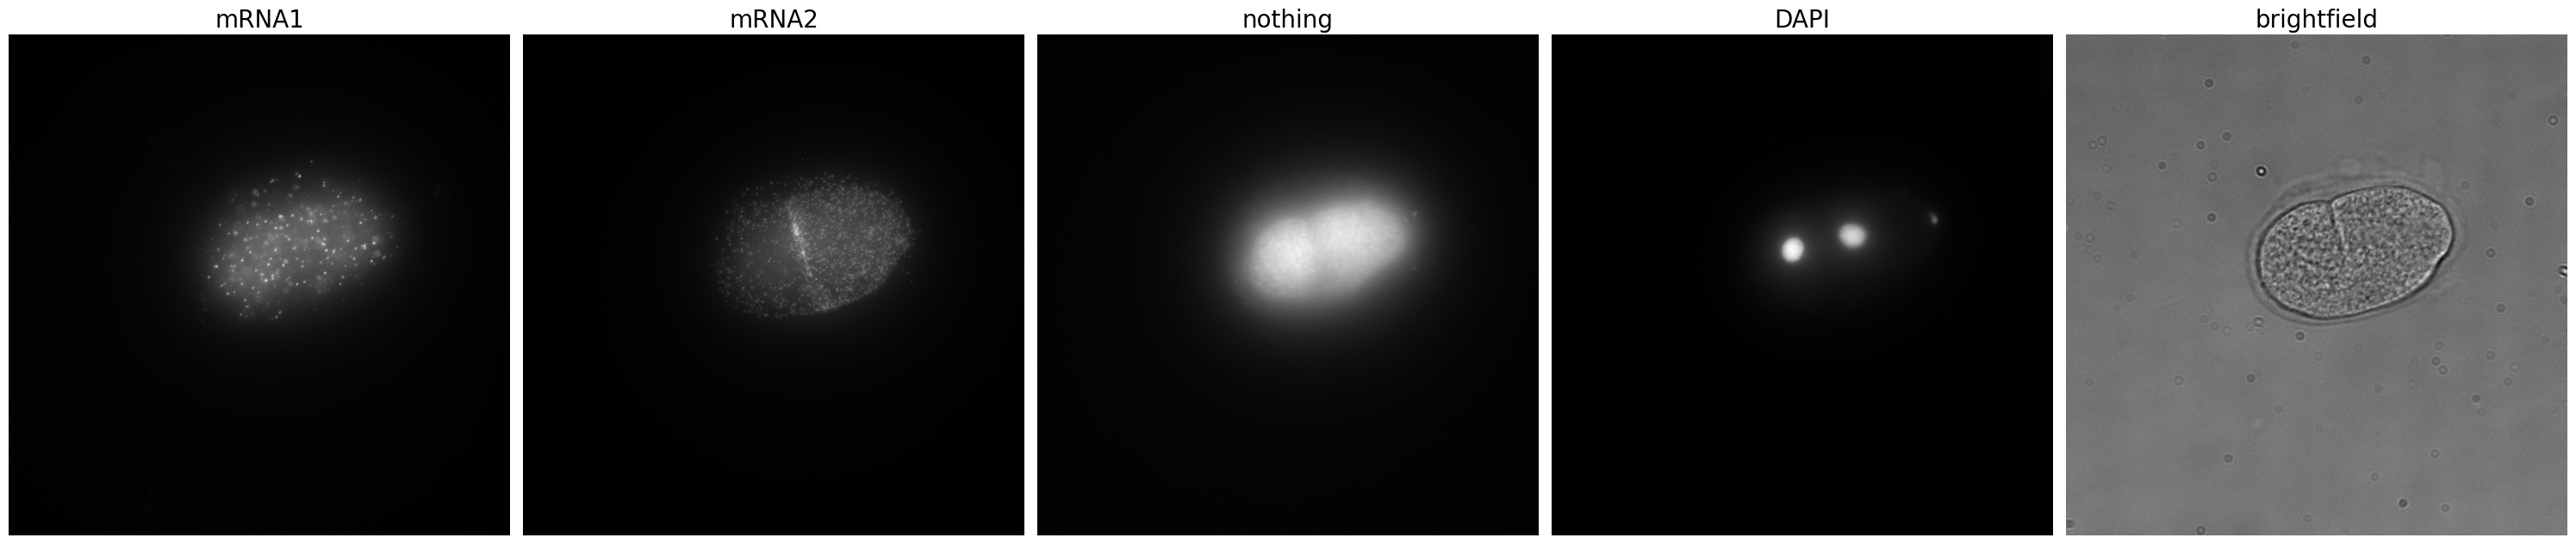

In [4]:
# #Read in Deltavision files

if dv_images:
    # Reading the microscopy data
    current_directory = os.getcwd()
    folder_path = os.path.join(current_directory, folder_name)

    if os.path.exists(folder_path):
        # List the files in the folder
        list_filenames = os.listdir(folder_path)
        list_filenames = sorted(list_filenames)
        path_files = [os.path.join(folder_path, filename) for filename in list_filenames if not filename.startswith('.ipynb_checkpoints')]

        # Read DV files and store image stacks in list_images
        list_images = []
        for image in path_files:
            image_stack = stack.read_dv(image)
            list_images.append(image_stack)

    # Extract Image ID by removing the "_R3D_REF.dv" suffix
    dv_filename = list_filenames[1]
    if dv_filename.endswith("_R3D_REF.dv"):
        image_name = dv_filename[:-len("_R3D_REF.dv")]
    else:
        image_name = dv_filename
    print(f'Image ID: {image_name}', '\n')

    # Converting the image to a specific shape
    bf = list_images[1]  # [C,Z,Y,X]
    image_colors = list_images[0]  # Reference [Y,X]

    bf = bf.astype(np.uint16)
    image_colors = image_colors.astype(np.uint16)

    print(f'Image colors \n{list_filenames[0]}: {image_colors.shape} \n')
    print(f'Brightfield \n{list_filenames[1]}: {bf.shape}')
        
        
    # Explicitly assign channels from image_colors and bf
    Cy5_array = image_colors[0, :, :, :] if image_colors[0] is not None else None
    mCherry_array = image_colors[1, :, :, :] if image_colors[1] is not None else None
    FITC_array = image_colors[2, :, :, :] if image_colors[2] is not None else None
    nuclei_array = image_colors[3, :, :, :] if image_colors[3] is not None else None
    bf = bf if brightfield is not None else None


    # Explicitly assign channels from image_colors and bf
    image_Cy5 = np.max(image_colors[0, :, :, :], axis=0) if image_colors[0] is not None else None
    image_mCherry = np.max(image_colors[1, :, :, :], axis=0) if image_colors[1] is not None else None
    image_FITC = np.max(image_colors[2, :, :, :], axis=0) if image_colors[2] is not None else None
    image_nuclei = np.max(image_colors[3, :, :, :], axis=0) if image_colors[3] is not None else None
    bf = bf if brightfield is not None else None

    # Combine images into a list
    images = [image_Cy5, image_mCherry, image_FITC, image_nuclei, bf]
    titles = [Cy5, mCherry, FITC, DAPI, brightfield]

    # Filter out None entries
    filtered_images = [(img, title) for img, title in zip(images, titles) if img is not None]

    # Plot the filtered images
    fig, ax = plt.subplots(1, len(filtered_images), figsize=(6 * len(filtered_images), 8))

    # Ensure ax is iterable
    if len(filtered_images) == 1:
        ax = [ax]

    for i, (img, title) in enumerate(filtered_images):
        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(title, size=20)
        ax[i].axis("off")

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f'channels_{image_name}.png'))
    plt.show()
    plt.close()

    
    grid_width=80
    grid_height=80

#### 2.2 Nikon files

In [5]:
# Process nd2 images

if nd2_images:
    # Reading the microscopy data
    current_directory = os.getcwd()
    folder_path = os.path.join(current_directory, folder_name)

    if os.path.exists(folder_path):
        # List the files in the folder
        list_filenames = os.listdir(folder_path)
        list_filenames = sorted(list_filenames)
        path_files = [
            os.path.join(folder_path, filename)
            for filename in list_filenames
            if not filename.startswith(".ipynb_checkpoints")
        ]

        # Read ND2 files and store image stacks in list_images
        list_images = []
        for image in path_files:
            image_stack = nd2.imread(image)  # Read ND2 image
            list_images.append(image_stack)

    # Extract Image ID
    image_name = list_filenames[0]
    print(f"Image ID: {image_name}\n")

    # Check the dimensions of the first image stack
    image_colors = list_images[0]  # Example shape: [T, C, Y, X]
    print(f"Image colors \n{list_filenames[0]}: {image_colors.shape}\n")


    # Define channel names and process max projections
    channels = [Cy5, mCherry, FITC, DAPI, brightfield]
    titles = channels

    # Explicitly assign channels from image_colors and bf
    Cy5_array = image_colors[:, 0, :, :] if image_colors[0] is not None else None
    mCherry_array = image_colors[:, 1, :, :] if image_colors[1] is not None else None
    FITC_array = image_colors[:, 2, :, :] if image_colors[2] is not None else None
    nuclei_array = image_colors[:, 3, :, :] if image_colors[3] is not None else None
    bf = image_colors[:, 4, :, :] if image_colors[4] is not None else None
    
    # Explicitly process each channel
    image_Cy5 = np.max(image_colors[:, 0, :, :], axis=0) if Cy5 else None
    image_mCherry = np.max(image_colors[:, 1, :, :], axis=0) if mCherry else None
    image_FITC = np.max(image_colors[:, 2, :, :], axis=0) if FITC else None
    image_nuclei = np.max(image_colors[:, 3, :, :], axis=0) if DAPI else None
    bf = np.max(image_colors[:, 4, :, :], axis=0) if brightfield else None ## something diff here

    # Combine the images into a list
    images = [image_Cy5, image_mCherry, image_FITC, image_nuclei, bf]

    # Filter out None entries
    filtered_images = [(img, title) for img, title in zip(images, titles) if img is not None]

    # Plotting the images
    fig, ax = plt.subplots(1, len(filtered_images), figsize=(6 * len(filtered_images), 8))

    # Ensure ax is always iterable, even if there's only one plot
    if len(filtered_images) == 1:
        ax = [ax]

    for i, (img, title) in enumerate(filtered_images):
        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(title, size=20)
        ax[i].axis("off")

    # Adjust layout and save the plots in the results folder
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, "channels_" + image_name + ".png"))
    plt.show()
    plt.close()

    
    grid_width=80
    grid_height=60


#### 2.3 Tiff files

In [6]:
# #Read .tif or .tiff images

if tiff_images:
    def tiff_images(folder_name, output_directory, slice_to_plot=0):
        current_directory = os.getcwd()
        mask_path = os.path.join(current_directory, folder_name)

        if not os.path.exists(mask_path):
            print("Folder does not exist.")
            return

        # List the files in the folder
        list_filenames = sorted([
            f for f in os.listdir(mask_path)
            if f.endswith(".tif") or f.endswith(".tiff")
        ])

        if len(list_filenames) == 0:
            print("No TIFF files found in folder.")
            return

        path_files = [os.path.join(mask_path, filename) for filename in list_filenames]
        list_images = [tiff.imread(image) for image in path_files]

        # Use first image
        image_stack = list_images[0]
        print(f"Image ID: {list_filenames[0]}")
        print(f"Image shape: {image_stack.shape}")

        # Plot the specified slice (handle 2D or 3D)
        if image_stack.ndim == 3:
            total_z = image_stack.shape[0]
            if slice_to_plot >= total_z:
                print(f"slice_to_plot ({slice_to_plot}) exceeds total slices ({total_z}), showing slice 0 instead.")
                slice_to_plot = 0
            plt.imshow(image_stack[slice_to_plot], cmap='gray')
            plt.title(f"Slice {slice_to_plot} of {total_z}")
        else:
            plt.imshow(image_stack, cmap='gray')
            plt.title("2D Image")

        plt.axis('off')
        plt.show()

        return image_stack  # Return the raw image for further processing

    # Example usage
    image_data = tiff_images(folder_name, output_directory, slice_to_plot=12)


## 3. Segmentation

#### 3.1 Single cell segmentation (optimized for <4-cell embryos)

/tmp/ipykernel_513289/4150116470.py:114: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  filtered_cyto = morphology.remove_small_objects(masks_cytosol_unfiltered, min_size=MIN_CELL_SIZE)


Cell segmentation took 1.18 minutes.
Cell segmentation finished. Skipping embryo segmentation.


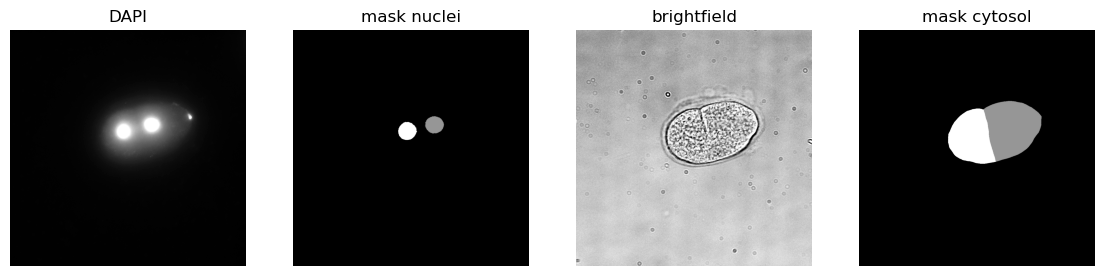

In [7]:
#### 1.1 Single cell segmentation (up to 4-cell embryos)

# Additional functions used for segmentation
def is_nucleus_in_cytosol(mask_n, mask_c):
    mask_n[mask_n>1]=1
    mask_c[mask_c>1]=1
    size_mask_n = np.count_nonzero(mask_n)
    size_mask_c = np.count_nonzero(mask_c)
    min_size =np.min( (size_mask_n,size_mask_c) )
    mask_combined =  mask_n + mask_c
    sum_mask = np.count_nonzero(mask_combined[mask_combined==2])
    if (sum_mask> min_size*0.8) and (min_size>200): # the element is inside if the two masks overlap over the 80% of the smaller mask.
        return 1
    else:
        return 0
    
def remove_lonely_masks(masks_0, masks_1,is_nuc=None):
    n_mask_0 = np.max(masks_0)
    n_mask_1 = np.max(masks_1)
    if (n_mask_0>0) and (n_mask_1>0):
        for ind_0 in range(1,n_mask_0+1):
            tested_mask_0 = erosion(np.where(masks_0 == ind_0, 1, 0))
            array_paired= np.zeros(n_mask_1)
            for ind_1 in range(1,n_mask_1+1):
                tested_mask_1 = erosion(np.where(masks_1 == ind_1, 1, 0))
                array_paired[ind_1-1] = is_nucleus_in_cytosol(tested_mask_1, tested_mask_0)
                if (is_nuc =='nuc') and (np.count_nonzero(tested_mask_0) > np.count_nonzero(tested_mask_1) ):
                    # condition that rejects images with nucleus bigger than the cytosol
                    array_paired[ind_1-1] = 0
                elif (is_nuc is None ) and (np.count_nonzero(tested_mask_1) > np.count_nonzero(tested_mask_0) ):
                    array_paired[ind_1-1] = 0
            if any (array_paired) == False: # If the cytosol is not associated with any mask.
                masks_0 = np.where(masks_0 == ind_0, 0, masks_0)
            masks_with_pairs = masks_0
    else:
        masks_with_pairs = np.zeros_like(masks_0)
    return masks_with_pairs

def matching_masks(masks_cyto, masks_nuclei):
    n_mask_cyto = np.max(masks_cyto)
    n_mask_nuc = np.max(masks_nuclei)
    new_masks_nuclei = np.zeros_like(masks_cyto)
    reordered_mask_nuclei = np.zeros_like(masks_cyto)
    if (n_mask_cyto>0) and (n_mask_nuc>0):
        for mc in range(1,n_mask_cyto+1):
            tested_mask_cyto = np.where(masks_cyto == mc, 1, 0)
            for mn in range(1,n_mask_nuc+1):
                mask_paired = False
                tested_mask_nuc = np.where(masks_nuclei == mn, 1, 0)
                mask_paired = is_nucleus_in_cytosol(tested_mask_nuc, tested_mask_cyto)
                if mask_paired == True:
                    if np.count_nonzero(new_masks_nuclei) ==0:
                        new_masks_nuclei = np.where(masks_nuclei == mn, -mc, masks_nuclei)
                    else:
                        new_masks_nuclei = np.where(new_masks_nuclei == mn, -mc, new_masks_nuclei)
            reordered_mask_nuclei = np.absolute(new_masks_nuclei)
    return reordered_mask_nuclei

def remove_extreme_values(image,min_percentile=0.1, max_percentile=99.5):
    max_val = np.percentile(image, max_percentile)
    min_val = np.percentile(image, min_percentile)
    image [image < min_val] = min_val
    image [image > max_val] = max_val
    return image

def metric_max_cells_and_area(masks):
    n_masks = np.max(masks)
    if n_masks > 1: # detecting if more than 1 mask are detected per cell
        size_mask = []
        for nm in range (1, n_masks+1): # iterating for each mask in a given cell. The mask has values from 0 for background, to int n, where n is the number of detected masks.
            approximated_radius = np.sqrt(np.sum(masks == nm)/np.pi)  # a=  pi r2
            size_mask.append(approximated_radius) #np.sum(masks == nm)) # creating a list with the size of each mask
        size_masks_array = np.array(size_mask)
        metric = np.mean(size_masks_array).astype(int) * n_masks
    elif n_masks == 1: # do nothing if only a single mask is detected per image.
        approximated_radius = np.sqrt(np.sum(masks == 1)/np.pi) 
        metric = approximated_radius.astype(int)
    else:  # return zero if no mask are detected
        metric = 0  
    return metric   

def nuclear_segmentation(image_nuclei):
    MIN_CELL_SIZE = 1000
    list_masks_nuclei = []
#     list_thresholds = np.arange(0.7,0.95, 0.05) # for dv images
    list_thresholds = np.arange(0.7,0.95, 0.05) # for nd2 images
    array_number_detected_masks = np.zeros(len(list_thresholds))
    for i,tested_ts in enumerate(list_thresholds):
        image_nuclei_binary = image_nuclei.copy()
        max_value_image = np.max(image_nuclei_binary)
        image_nuclei_binary[image_nuclei_binary < max_value_image*tested_ts] = 0
        image_nuclei_binary[image_nuclei_binary > max_value_image*tested_ts] = 1
        labels = measure.label(image_nuclei_binary)
        filtered_labels = morphology.remove_small_objects(labels, min_size=MIN_CELL_SIZE)
        unique_filtered_labels = np.unique(filtered_labels)
        tested_masks_nuclei = np.zeros_like(filtered_labels)
        for idx, old_label in enumerate(unique_filtered_labels):
            tested_masks_nuclei[filtered_labels == old_label] = idx
        list_masks_nuclei.append(tested_masks_nuclei)
        array_number_detected_masks[i]= metric_max_cells_and_area( tested_masks_nuclei) 
    selected_index = np.argmax(array_number_detected_masks)
    masks_nuclei = list_masks_nuclei [selected_index]
    return masks_nuclei

def cytosol_segmentation(image_cytosol,second_image_cytosol,cytosol_diameter):
    flow_ts=1
    MIN_CELL_SIZE = 1000 #100000 -> segmented the entire embryo
    model = models.Cellpose(gpu=True, model_type='cyto2') # model_type='cyto', 'cyto2' or model_type='nuclei'
    if not (second_image_cytosol is None):
        merged_image_cytosol = np.concatenate((image_cytosol[:, :, np.newaxis], second_image_cytosol[:, :, np.newaxis]), axis=2)
        masks_cytosol_unfiltered = model.eval(merged_image_cytosol, diameter=cytosol_diameter, flow_threshold=flow_ts, channels=[0,1])[0]
    else:
        masks_cytosol_unfiltered = model.eval(image_cytosol, diameter=cytosol_diameter, flow_threshold=flow_ts, channels=[0,0])[0]
    filtered_cyto = morphology.remove_small_objects(masks_cytosol_unfiltered, min_size=MIN_CELL_SIZE)
    unique_filtered_cyto = np.unique(filtered_cyto)
    masks_cytosol = np.zeros_like(filtered_cyto)
    for idx, old_label in enumerate(unique_filtered_cyto):
        masks_cytosol[filtered_cyto == old_label] = idx
    return masks_cytosol


def segmentation_optimization(image_cytosol,image_nuclei,cytosol_diameter,second_image_cytosol=None):
    # Cytosol segmentation
    masks_cytosol =cytosol_segmentation(image_cytosol,second_image_cytosol,cytosol_diameter)
    # Nuclear segmentation
    masks_nuclei = nuclear_segmentation(image_nuclei)
    # reordering nuclei masks
    masks_nuclei = matching_masks(masks_cytosol,masks_nuclei)
    # remove masks without nuclei
    masks_nuclei= remove_lonely_masks(masks_0=masks_nuclei , masks_1=masks_cytosol,is_nuc='nuc')
    masks_cytosol= remove_lonely_masks(masks_0=masks_cytosol , masks_1=masks_nuclei)
    # calculate size of masks
    number_masks_cyto = np.max(masks_cytosol)
    list_masks_cyto_sizes =[]
    for i in range (1, number_masks_cyto+1):
        list_masks_cyto_sizes.append(len(masks_cytosol[masks_cytosol==i]) )
    number_masks_nuc = np.max(masks_nuclei)
    list_masks_nuc_sizes =[]
    for i in range (1, number_masks_nuc+1):
        list_masks_nuc_sizes.append(len(masks_nuclei[masks_nuclei==i]) )
    return masks_nuclei, masks_cytosol,list_masks_nuc_sizes, list_masks_cyto_sizes


# Codes used to segment the nucleus and the cytosol
def segmentation(image_cytosol,image_nuclei, second_image_cytosol=None):
    # removing outliers in image
    image_cytosol = remove_extreme_values(image=image_cytosol,min_percentile=0.1, max_percentile=99.5)
    if not (second_image_cytosol is None):
        second_image_cytosol = remove_extreme_values(image=second_image_cytosol,min_percentile=0.1, max_percentile=99.5)
    image_nuclei = remove_extreme_values(image=image_nuclei,min_percentile=0.1, max_percentile=99.5)
    # Optimization segmentation
    list_masks_nuclei = []
    list_masks_cytosol=[]
    list_masks_nuc_sizes =[]
    list_masks_cyto_sizes=[]
    list_flow_thresholds = np.arange(40, 200, 10)
    array_number_detected_masks = np.zeros(len(list_flow_thresholds))
    for i,tested_ts in enumerate(list_flow_thresholds):
        tested_masks_nuclei, tested_masks_cytosol, tested_list_masks_nuc_sizes, tested_list_masks_cyto_sizes = segmentation_optimization(image_cytosol,image_nuclei,cytosol_diameter=tested_ts,second_image_cytosol=second_image_cytosol)
        list_masks_nuclei.append(tested_masks_nuclei)
        list_masks_cytosol.append(tested_masks_cytosol)
        list_masks_nuc_sizes.append(tested_list_masks_nuc_sizes)
        list_masks_cyto_sizes.append(tested_list_masks_cyto_sizes)
        array_number_detected_masks[i]= metric_max_cells_and_area( tested_masks_cytosol) + metric_max_cells_and_area( tested_masks_nuclei)
    selected_index = np.argmax(array_number_detected_masks)
    masks_nuclei = list_masks_nuclei [selected_index]
    masks_cytosol = list_masks_cytosol [selected_index]
    masks_nuc_sizes = list_masks_nuc_sizes[selected_index]
    masks_cyto_sizes = list_masks_cyto_sizes[selected_index]
    
    # Save cyto masks as arrays
    masks_cytosol = np.array(masks_cytosol)
    tiff.imwrite(os.path.join(output_directory, "masks_cytosol.tif"), masks_cytosol.astype(masks_cytosol.dtype))
    
    
        # Plotting
    color_map = 'Greys_r'
    fig, ax = plt.subplots(1,4, figsize=(14, 4))
    # Plotting the heatmap of a section in the image
    ax[0].imshow(image_nuclei,cmap=color_map)
    ax[1].imshow(masks_nuclei,cmap=color_map)
    ax[2].imshow(image_cytosol,cmap=color_map)
    ax[3].imshow(masks_cytosol,cmap=color_map)
    ax[0].set(title='DAPI'); ax[0].axis('off');ax[0].grid(False)
    ax[1].set(title='mask nuclei'); ax[1].axis('off');ax[1].grid(False)
    ax[2].set(title='brightfield'); ax[2].axis('off');ax[2].grid(False)
    ax[3].set(title='mask cytosol'); ax[3].axis('off');ax[3].grid(False)


    return masks_cytosol, masks_nuclei, masks_cyto_sizes, masks_nuc_sizes

###### # Run cell segmentation function but default to embryo segmentation if longer than 10 min (time coditional):

if run_cell_segmentation:
    try:
        start_time = time.time()

        image_cytosol = bf
        second_image_cytosol = image_nuclei
        masks_cytosol, masks_nuclei, list_masks_cyto_sizes, list_masks_nuc_sizes = segmentation(
            image_cytosol, image_nuclei, second_image_cytosol
        )

        # Save segmentation figure
        segmentation_filename = os.path.join(output_directory, f'cell_segmentation_{image_name}.png')
        plt.savefig(segmentation_filename)

        elapsed_time = time.time() - start_time
        print(f"Cell segmentation took {elapsed_time / 60:.2f} minutes.")

        if elapsed_time > 600:
            print("Cell segmentation timed out. Proceeding to embryo segmentation.")
            run_embryo_segmentation = True
        else:
            print("Cell segmentation finished. Skipping embryo segmentation.")
            run_embryo_segmentation = False

    except Exception as e:
        print(f"Cell segmentation failed with error: {e}")
        print("Running embryo segmentation...")
        run_embryo_segmentation = False


#### 3.2 Cell stage sorting

In [8]:
# #Sort images based on nuclei
def get_cell_stage_and_size_filtered(masks_nuclei, min_fraction_median=0.2):
    # Label connected components
    labeled_mask, num_nuclei = label(masks_nuclei, return_num=True)
    
    # XY pixel size in nm
    pixel_size_xy = voxel_size[1]
    
    # First pass: get all areas
    all_areas = np.array([region.area for region in regionprops(labeled_mask)])
    if len(all_areas) == 0:
        print("No nuclei detected")
        return "no-nuclei", [], np.zeros_like(masks_nuclei)  # <-- modified to return 3 values
    
    median_area = np.median(all_areas)
    min_area_pixels = median_area * min_fraction_median  # dynamically filter small outliers
    
    # Map number of nuclei to stage (after filtering)
    filtered_mask = np.zeros_like(labeled_mask)
    nuclei_sizes = []
    label_idx = 1
    for region in regionprops(labeled_mask):
        if region.area < min_area_pixels:
            continue  # skip very small outliers
        
        # keep in filtered mask
        filtered_mask[labeled_mask == region.label] = label_idx
        
        # Approximate diameter in pixels (assume circular)
        diameter_pixels = 2 * np.sqrt(region.area / np.pi)
        area_um2 = region.area * (pixel_size_xy / 1000)**2
        diameter_um = diameter_pixels * (pixel_size_xy / 1000)
        
        nuclei_sizes.append({
            "label": label_idx,
            "area_pixels": region.area,
            "diameter_pixels": diameter_pixels,
            "area_um2": area_um2,
            "diameter_um": diameter_um
        })
        label_idx += 1
    
    # Determine cell stage based on filtered nuclei
    num_filtered = len(nuclei_sizes)
    stage_map = {1: "1-cell", 2: "2-cell", 4: "4-cell"}
    stage = stage_map.get(num_filtered, f"{num_filtered}-cell")
    
    print(f"Detected {num_filtered} nuclei after filtering → Stage: {stage}")
    
    return stage, nuclei_sizes, filtered_mask


# Usage
if run_cell_segmentation:
    cell_stage, nuclei_sizes, masks_filtered = get_cell_stage_and_size_filtered(masks_nuclei)

run_2cell_classifier = False
run_4cell_classifier = False
run_embryo_segmentation = False  # make sure this is initialized

if run_cell_classifier:
    if cell_stage in ["no-nuclei"]:
        run_embryo_segmentation = True
        run_cell_classifier=False
    elif cell_stage == "2-cell":
        run_2cell_classifier = True
    elif cell_stage == "4-cell":
        run_4cell_classifier = True
    else:
        run_embryo_segmentation = True
        run_cell_classifier=False
else:
    print("Skipped classifier")
    
print(f"run_2cell_classifier = {run_2cell_classifier}")
print(f"run_4cell_classifier = {run_4cell_classifier}")
print(f"run_embryo_segmentation = {run_embryo_segmentation}")


Detected 2 nuclei after filtering → Stage: 2-cell
run_2cell_classifier = True
run_4cell_classifier = False
run_embryo_segmentation = False


#### 3.3 Classify masks with biological names

##### 3.3.1 (2-cell) AB-P1-cell classifier

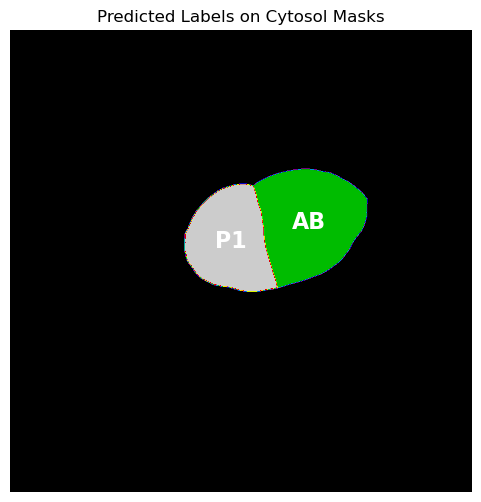

   label     area   perimeter  eccentricity  solidity    extent  \
0      1  46896.0  869.873196      0.409853  0.984011  0.704906   
1      2  35266.0  763.263023      0.638546  0.976032  0.716294   

   major_axis_length  minor_axis_length  mean_intensity  bbox-0  ...  \
0         260.891959         237.973036      567.894767     308  ...   
1         247.820851         190.718969      562.722225     341  ...   

   orientation  centroid_y  centroid_x  initial_prediction  \
0    -0.378871  424.730020  661.424279                  AB   
1     0.227246  468.163047  488.329978                  P1   

   prediction_confidence  rel_pos_minor  AB_conf  P1_conf  \
0                   0.88      -0.184913     0.88     0.12   
1                   0.52       0.242206     0.48     0.52   

  highest_confidence_label  nearby_cells  
0                       AB          True  
1                       P1          True  

[2 rows x 25 columns]


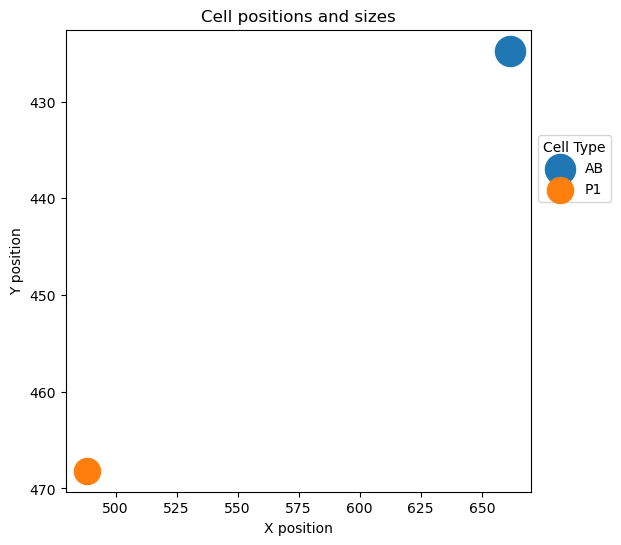

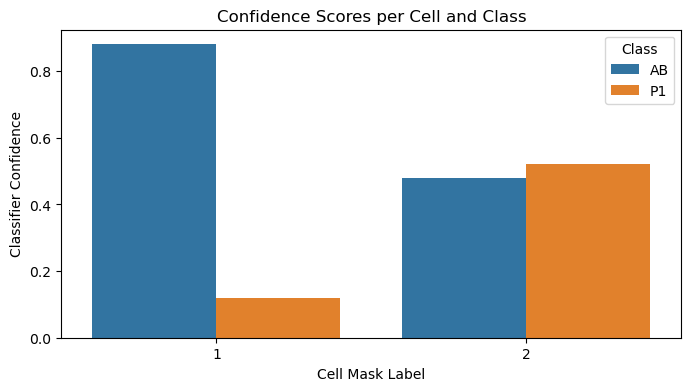

In [9]:
### 2-cell classifier

# Suppress just the InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

if run_2cell_classifier:
    # --- Extract features of unseen brightfield image for classification ---
    props_unseen = regionprops_table(
        masks_cytosol,
        intensity_image=bf,
        properties=[
            'label', 'area', 'perimeter', 'eccentricity', 'solidity', 'extent',
            'major_axis_length', 'minor_axis_length', 'mean_intensity',
            'bbox', 'centroid', 'orientation'
        ]
    )

    # Convert to DataFrame
    features_df = pd.DataFrame(props_unseen)

    # Rename centroids for convenience
    features_df['centroid_y'] = features_df['centroid-0']
    features_df['centroid_x'] = features_df['centroid-1']

    # Load trained Random Forest model
    rf = joblib.load("models/2-cell_classification_RFmodel.joblib")

    # --- Select the features used during training ---
    X_new = features_df[
        [
            'area', 'perimeter', 'eccentricity', 'solidity', 'extent',
            'major_axis_length', 'minor_axis_length', 'mean_intensity',
            'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3',
            'centroid-0', 'centroid-1',
            'orientation'
        ]
    ]

    # --- Predict cell type and probabilities ---
    predictions = rf.predict(X_new)
    proba = rf.predict_proba(X_new)
    classes = rf.classes_

    # --- Get confidence scores ---
    predicted_class_indices = [list(classes).index(pred) for pred in predictions]
    prediction_confidence = [proba[i][idx] for i, idx in enumerate(predicted_class_indices)]

    # Add predictions and confidence to dataframe
    features_df["initial_prediction"] = predictions
    features_df["prediction_confidence"] = prediction_confidence
    
    # --- Fit ellipse to entire embryo ---
    binary_image = (masks_cytosol > 0).astype(np.uint8)
    contours = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    if contours and len(contours[0]) >= 5:
        cnt = max(contours, key=cv2.contourArea)
        ellipse = cv2.fitEllipse(cnt)
        (xc, yc), (d1, d2), angle = ellipse  # center, axes, rotation
        theta = np.deg2rad(angle)
        minor_axis_vec = np.array([-np.sin(theta), np.cos(theta)])  # along minor axis

        # Compute relative minor-axis positions for each cell
        rel_positions = []
        for _, row in features_df.iterrows():
            centroid = np.array([row['centroid_x'], row['centroid_y']])
            vec_from_center = centroid - np.array([xc, yc])
            rel_pos_minor = np.dot(vec_from_center, minor_axis_vec) / d2  # normalized
            rel_positions.append(rel_pos_minor)
        features_df['rel_pos_minor'] = rel_positions

    # ---- Fail-safe logic: Ensure exactly one AB and one P1 ----
    ab_idx = list(classes).index("AB")
    p1_idx = list(classes).index("P1")

    # Rank cells by their AB and P1 confidence
    features_df["AB_conf"] = proba[:, ab_idx]
    features_df["P1_conf"] = proba[:, p1_idx]

    # Assign highest AB_conf as AB, highest P1_conf as P1
    ab_row = features_df.loc[features_df["AB_conf"].idxmax()]
    p1_row = features_df.loc[features_df["P1_conf"].idxmax()]

    # Assign labels
    features_df["highest_confidence_label"] = "Unassigned"
    features_df.loc[ab_row.name, "highest_confidence_label"] = "AB"
    features_df.loc[p1_row.name, "highest_confidence_label"] = "P1"
    
    # --- Extract AB and P1 masks ---
    ab_mask = (masks_cytosol == ab_row['label'])
    p1_mask = (masks_cytosol == p1_row['label'])

    # Dilate slightly to ensure boundary contact detection
    ab_dilated = binary_dilation(ab_mask, iterations=1)
    p1_dilated = binary_dilation(p1_mask, iterations=1)

    touching = np.any(ab_dilated & p1_mask) or np.any(p1_dilated & ab_mask)

    if not touching:
        print(f"Fail-safe triggered for {image_name}: AB and P1 are not touching.")
        features_df.loc[ab_row.name, "highest_confidence_label"] = "Unassigned"
        features_df.loc[p1_row.name, "highest_confidence_label"] = "Unassigned"
        features_df["nearby_cells"] = False
    else:
        features_df["nearby_cells"] = True

    # --- Plot prediction labels ---
    mask_image = np.max(masks_cytosol, axis=0) if masks_cytosol.ndim == 3 else masks_cytosol
    plt.figure(figsize=(6, 6))
    plt.imshow(mask_image, cmap='nipy_spectral')
    plt.axis('off')

    for _, row in features_df.iterrows():
        label = row['label']
        pred_label = row['highest_confidence_label']
        y, x = center_of_mass(mask_image == label)
        plt.text(x, y, pred_label, color='white', fontsize=16,
                 ha='center', va='center', weight='bold')

    plt.title("Predicted Labels on Cytosol Masks")
    predicted_label_filename = os.path.join(output_directory, f'predicted_label_{image_name}.png')
    plt.savefig(predicted_label_filename, dpi=300, bbox_inches='tight')
    plt.show()

    # --- Save outputs ---
    features_df_output = os.path.join(output_directory, f'features_df_{image_name}.csv')
    features_df.to_csv(features_df_output, index=False)

    print(features_df.tail())
    
    # --- Plot cell centroid position ---
    plt.figure(figsize=(6,6))
    for label, group in features_df.groupby('highest_confidence_label'):
        plt.scatter(group['centroid_x'], group['centroid_y'], 
                    s=group['area']/100, label=label)

    plt.gca().invert_yaxis()  # Match image coordinates
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.title("Cell positions and sizes")

    # Move legend outside the plot
    plt.legend(title="Cell Type", loc='center left', bbox_to_anchor=(1, 0.7))

    # Save figure
    centroid_position_plot_filename = os.path.join(output_directory, f'centroid_position_plot_{image_name}.png')
    plt.savefig(centroid_position_plot_filename, dpi=300, bbox_inches='tight')
    plt.show()


    # --- Plot prediction confidence ---
    conf_cols = ['AB_conf', 'P1_conf']
    conf_df = features_df.melt(id_vars='label', value_vars=conf_cols,
                               var_name='class', value_name='confidence')
    conf_df['class'] = conf_df['class'].str.replace('_conf','')

    plt.figure(figsize=(8,4))
    sns.barplot(data=conf_df, x='label', y='confidence', hue='class')
    plt.ylabel("Classifier Confidence")
    plt.xlabel("Cell Mask Label")
    plt.title("Confidence Scores per Cell and Class")
    plt.legend(title="Class")
    cell_confidence_plot_filename = os.path.join(output_directory, f'cell_confidence_plot_{image_name}.png')
    plt.savefig(cell_confidence_plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping 2-cell classifier...")

##### 3.3.2 (4-cell) ABa, ABp, EMS, P2 classifier

In [10]:
### 4-cell classifier

# Suppress just the InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

if run_4cell_classifier:
    # --- Extract base features ---
    props_unseen = regionprops_table(
        masks_cytosol,
        intensity_image=bf,
        properties=[
            'label', 'area', 'perimeter', 'eccentricity', 'solidity', 'extent',
            'major_axis_length', 'minor_axis_length', 'mean_intensity',
            'bbox', 'centroid', 'orientation'
        ]
    )
    features_df = pd.DataFrame(props_unseen)
    # --- define centroid_x / centroid_y ---
    features_df['centroid_y'] = features_df['centroid-0']
    features_df['centroid_x'] = features_df['centroid-1']

    # --- Apply filters once to whole BF image ---
    bf_float = img_as_float(bf)
    smooth = filters.gaussian(bf_float, sigma=1)
    sobel_edges = filters.sobel(smooth)
    median_filtered = filters.rank.median(
        (bf / bf.max() * 255).astype(np.uint8),
        disk(3)
    )

    # --- Add per-cell filtered stats ---
    extra_features = []
    for lbl in features_df['label']:
        mask = (masks_cytosol == lbl)
        extra_features.append({
            "smooth_mean": np.mean(smooth[mask]),
            "smooth_std": np.std(smooth[mask]),
            "smooth_median": np.median(smooth[mask]),
            "sobel_mean": np.mean(sobel_edges[mask]),
            "sobel_std": np.std(sobel_edges[mask]),
            "sobel_median": np.median(sobel_edges[mask]),
            "medianf_mean": np.mean(median_filtered[mask]),
            "medianf_std": np.std(median_filtered[mask]),
            "medianf_median": np.median(median_filtered[mask])
        })
    extra_df = pd.DataFrame(extra_features)
    features_df = pd.concat([features_df, extra_df], axis=1)

    # --- Load model ---
    rf = joblib.load("models/4-cell_classification_RFmodel.joblib")

    # --- Match training feature order ---
    X_new = features_df[
        [
            'area', 'perimeter', 'eccentricity', 'solidity', 'extent',
            'major_axis_length', 'minor_axis_length', 'mean_intensity',
            'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3',
            'centroid-0', 'centroid-1',
            'orientation',
            'smooth_mean', 'smooth_std', 'smooth_median',
            'sobel_mean', 'sobel_std', 'sobel_median',
            'medianf_mean', 'medianf_std', 'medianf_median'
        ]
    ]

    # --- Predict ---
    proba = rf.predict_proba(X_new)
    classes = rf.classes_
    initial_preds = rf.predict(X_new)

    # --- Confidence scores ---
    predicted_class_indices = [list(classes).index(pred) for pred in initial_preds]
    prediction_confidence = [proba[i][idx] for i, idx in enumerate(predicted_class_indices)]
    features_df["initial_prediction"] = initial_preds
    features_df["prediction_confidence"] = prediction_confidence

    # --- Confidence for each class ---
    for cname in ["ABa", "ABp", "EMS", "P2"]:
        features_df[f"{cname}_conf"] = proba[:, list(classes).index(cname)]

    # --- Fail-safe: ensure one label per class ---
    features_df["highest_confidence_label"] = "Unassigned"
    for cname in ["ABa", "ABp", "EMS", "P2"]:
        features_df.loc[features_df[f"{cname}_conf"].idxmax(), "highest_confidence_label"] = cname

    # --- Positional fail-safe using ellipse ---
    # Fit ellipse to entire embryo
    binary_image = (masks_cytosol > 0).astype(np.uint8)
    contours = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    if contours and len(contours[0]) >= 5:
        cnt = max(contours, key=cv2.contourArea)
        ellipse = cv2.fitEllipse(cnt)
        (xc, yc), (d1, d2), angle = ellipse  # center, axes, rotation
        theta = np.deg2rad(angle)
        minor_axis_vec = np.array([-np.sin(theta), np.cos(theta)])  # along minor axis

        # Compute relative minor-axis positions for each cell
        rel_positions = []
        for idx, row in features_df.iterrows():
            centroid = np.array([row['centroid_x'], row['centroid_y']])
            vec_from_center = centroid - np.array([xc, yc])
            rel_pos_minor = np.dot(vec_from_center, minor_axis_vec) / d2  # normalized
            rel_positions.append(rel_pos_minor)
        features_df['rel_pos_minor'] = rel_positions

        # Assign ABa / P2 at ends
        left_cell = features_df.loc[features_df['rel_pos_minor'].idxmin()]
        right_cell = features_df.loc[features_df['rel_pos_minor'].idxmax()]
        if left_cell['area'] > right_cell['area']:
            features_df.loc[left_cell.name, 'highest_confidence_label'] = 'ABa'
            features_df.loc[right_cell.name, 'highest_confidence_label'] = 'P2'
        else:
            features_df.loc[left_cell.name, 'highest_confidence_label'] = 'P2'
            features_df.loc[right_cell.name, 'highest_confidence_label'] = 'ABa'

        # Middle cells: EMS = smaller, ABp = larger
        middle_cells = features_df.drop([left_cell.name, right_cell.name])
        ems_cell = middle_cells.loc[middle_cells['area'].idxmin()]
        abp_cell = middle_cells.loc[middle_cells['area'].idxmax()]
        features_df.loc[ems_cell.name, 'highest_confidence_label'] = 'EMS'
        features_df.loc[abp_cell.name, 'highest_confidence_label'] = 'ABp'

    # --- Plot results ---
    mask_image = np.max(masks_cytosol, axis=0) if masks_cytosol.ndim == 3 else masks_cytosol
    plt.figure(figsize=(6, 6))
    plt.imshow(mask_image, cmap='nipy_spectral')
    plt.axis('off')

    for idx, row in features_df.iterrows():
        y, x = center_of_mass(mask_image == row['label'])
        plt.text(x, y, row['highest_confidence_label'], color='white',
                 fontsize=16, ha='center', va='center', weight='bold')

    plt.title("Predicted Labels on Cytosol Masks")

    # --- Save outputs ---
    features_df_output = os.path.join(output_directory, f'features_df_{image_name}.csv')
    features_df.to_csv(features_df_output, index=False)
    predicted_label_filename = os.path.join(output_directory, f'predicted_label_{image_name}.png')
    plt.savefig(predicted_label_filename, dpi=300, bbox_inches='tight')
    plt.show()

    print(features_df.tail())

   ## plot cell centroid position
    plt.figure(figsize=(6,6))
    for label, group in features_df.groupby('highest_confidence_label'):
        plt.scatter(group['centroid_x'], group['centroid_y'], 
                    s=group['area']/50, label=label)

    plt.gca().invert_yaxis()  # Match image coordinates
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.legend()
    plt.title("Cell positions and sizes")
    plt.show()
    
    # Save the figure
    centroid_position_plot_filename = os.path.join(output_directory, f'centroid_position_plot_{image_name}.png')
    plt.savefig(centroid_position_plot_filename, dpi=300, bbox_inches='tight')
    plt.show()



    ### plot prediction confidence per cell
    # Reshape dataframe for plotting
    conf_cols = ['ABa_conf', 'ABp_conf', 'EMS_conf', 'P2_conf']
    conf_df = features_df.melt(id_vars='label', value_vars=conf_cols,
                               var_name='class', value_name='confidence')

    # Strip "_conf" from class names
    conf_df['class'] = conf_df['class'].str.replace('_conf','')

    plt.figure(figsize=(8,4))
    sns.barplot(data=conf_df, x='label', y='confidence', hue='class')
    plt.ylabel("Classifier Confidence")
    plt.xlabel("Cell Mask Label")
    plt.title("Confidence Scores per Cell and Class")
    plt.legend(title="Class")
    plt.show()
    
    # Save the figure
    cell_confidence_plot_filename = os.path.join(output_directory, f'cell_confidence_plot_{image_name}.png')
    plt.savefig(cell_confidence_plot_filename, dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("Skipping 4-cell classifier...")

Skipping 4-cell classifier...


#### 3.4 Embryo Segementation

In [11]:
## Embryo segmentation

def keep_largest_region(mask):
    labels = measure.label(mask)
    props = measure.regionprops(labels)
    if not props:
        return mask * 0  # return empty if nothing found
    largest_region = max(props, key=lambda x: x.area)
    return (labels == largest_region.label).astype(np.uint16)

def embryo_segmentation(bf, image_nuclei, image_name, output_directory):
    cytosol_image = bf[..., 0] if bf.ndim == 3 else bf
    nuclei_image = image_nuclei[..., 0] if image_nuclei.ndim == 3 else image_nuclei

    # Run Cellpose for cytosol (large object: the embryo)
    model_cyto = models.Cellpose(model_type='cyto')
    masks_cytosol, _, _, _ = model_cyto.eval(
        cytosol_image, diameter=embryo_diameter, channels=[0, 0]
    )
    masks_cytosol = keep_largest_region(masks_cytosol)

    # Run Cellpose for nuclei (smaller, multiple objects)
    model_nuclei = models.Cellpose(model_type='cyto2')
    masks_nuclei, _, _, _ = model_nuclei.eval(
        nuclei_image, diameter=nuclei_diameter, channels=[0, 0],
        cellprob_threshold=0.0, flow_threshold=0.2
    )
    
    # --- Post-processing: remove size outliers ---
    labeled_nuc = label(masks_nuclei)
    props = regionprops(labeled_nuc)
    areas = np.array([p.area for p in props])

    if len(areas) > 0:
        median_area = np.median(areas)
        min_area_threshold = 0.5 * median_area  # tune 0.4-0.6 if needed
        max_area_threshold = 2.0 * median_area  # optional: remove huge artifacts

        masks_nuclei_filtered = np.zeros_like(labeled_nuc)
        label_idx = 1
        for p in props:
            if min_area_threshold <= p.area <= max_area_threshold:
                masks_nuclei_filtered[labeled_nuc == p.label] = label_idx
                label_idx += 1

        masks_nuclei = masks_nuclei_filtered
    
    # Get outlines
    outlines_cytosol = utils.outlines_list(masks_cytosol)
    outlines_nuclei = utils.outlines_list(masks_nuclei)

    # Compute sizes
    labeled_cyto = label(masks_cytosol.astype(np.uint16))
    masks_cyto_sizes = [prop.area for prop in regionprops(labeled_cyto)]
    masks_nuc_sizes = [prop.area for prop in regionprops(masks_nuclei)]

    # Plot side-by-side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(cytosol_image, cmap='gray')
    for o in outlines_cytosol:
        ax[0].plot(o[:, 0], o[:, 1], color='lime', linewidth=1)
    ax[0].set_title('Embryo Mask')
    ax[0].axis('off')

    ax[1].imshow(nuclei_image, cmap='gray')
    for o in outlines_nuclei:
        ax[1].plot(o[:, 0], o[:, 1], color='deepskyblue', linewidth=1)
    ax[1].set_title('Nuclei Mask')
    ax[1].axis('off')

    # Create binary mask for embryo outline
    image_shape = cytosol_image.shape
    embryo_outline = np.zeros(image_shape, dtype=bool)
    for outline in outlines_cytosol:
        poly_mask = polygon2mask(image_shape, outline[:, ::-1])
        embryo_outline |= poly_mask

    # Save cyto masks as arrays
    masks_cytosol = np.array(masks_cytosol)
    tiff.imwrite(os.path.join(output_directory, "masks_cytosol.tif"), masks_cytosol.astype(masks_cytosol.dtype))
    
    # Save figure
    segmentation_filename = os.path.join(output_directory, f'embryo_segmentation_{image_name}.png')
    plt.savefig(segmentation_filename)
    plt.tight_layout()
    plt.show()
    plt.close()

    return masks_cytosol, masks_nuclei, masks_cyto_sizes, masks_nuc_sizes

if run_embryo_segmentation:
    masks_cytosol, masks_nuclei, masks_cyto_sizes, masks_nuc_sizes = embryo_segmentation(
        bf, image_nuclei, image_name, output_directory
    )
else:
    print("Skipping embryo segmentation...")

Skipping embryo segmentation...


## 4. Spot detection

#### 4.1 Automated threshold selection and spot detection

In [ ]:
def spot_detection(rna,voxel_size,spot_radius,masks_cytosol):
    spots, threshold = detection.detect_spots(
        images= rna,
        return_threshold=True,
        voxel_size=voxel_size,
        spot_radius=spot_radius) 

    spot_radius_px = detection.get_object_radius_pixel(
        voxel_size_nm=voxel_size,
        object_radius_nm=spot_radius,
        ndim=3) 

    # LoG filter
    rna_log = stack.log_filter(rna, sigma=spot_radius_px)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

    # thresholding
    threshold = detection.automated_threshold_setting(rna_log, mask)
    spots, _ = detection.spots_thresholding(rna_log, mask, threshold)


    # Decompose regions by simulating as many spots as possible until we match the original region intensity.
    #spots_post_decomposition = spots.copy()
    spots_post_decomposition, dense_regions, reference_spot = detection.decompose_dense(
        image=rna,
        spots=spots,
        voxel_size=voxel_size,
        spot_radius=spot_radius,
        alpha=0.7,  # alpha impacts the number of spots per candidate region
        beta=1,  # beta impacts the number of candidate regions to decompose
        gamma=5)  # gamma the filtering step to denoise the image

    # define clusters
    spots_post_clustering, clusters = detection.detect_clusters(
        spots=spots_post_decomposition,
        voxel_size=voxel_size,
        radius=1136, #626 #1000
        nb_min_spots=5) #10

   # plotting
    print(f"Image ID: {image_name} \n")
    print(f"{rna_channel} detection")
    print(f" threshold: {threshold}")
    print("\r spots: {0}".format(spots_post_clustering.shape[0]))
    print("\r clusters: {0}".format(clusters.shape[0]))
   
        #elbow plot
    threshold_output = os.path.join(output_directory, rna_channel + '_threshold_' + image_name)
    plot.plot_elbow(
        images=rna,
        voxel_size=voxel_size,
        spot_radius=spot_radius,
        size_axes=8,
        framesize=(5, 3),
        title=(f"{rna_channel} detection threshold"),
        size_title=12,
        path_output=threshold_output,
        show=True  # Set show to False to hide the plot
    )

      
    #    # Save the plots in the results folder
    detection_output = os.path.join(output_directory, rna_channel + '_detection_' + image_name)
    plot.plot_detection(
        image=np.max(rna, axis=0),
        spots=[spots_post_decomposition, clusters[:, :3]],
        shape=["circle", "circle"],
        radius=[1, 4],
        color=detection_color,
        linewidth=[3, 2],
        fill=[False, True],
        contrast=True,
        framesize=(10, 5),
        title=(f"{rna_channel} detection"),
        path_output= detection_output,
        show=True
    )


    #spots_no_ts, _, ts = multistack.remove_transcription_site(spotDetectionCSV, clusterDetectionCSV, mask_nuc, ndim=3)
    #spots_in_region, _ = multistack.identify_objects_in_region(mask, spots_post_clustering[:,:3], ndim=3)

    # Separating and counting the spots in each cell
    number_masks_cyto = np.max(masks_cytosol)
    list_spots_in_each_cell =[]
    list_clusters_in_each_cell =[]
    for i in range (1, number_masks_cyto+1):
        temp_cyto_mask= np.zeros_like(masks_cytosol)
        temp_cyto_mask[masks_cytosol == i] = i
        spots_in_region, _ = multistack.identify_objects_in_region(mask=temp_cyto_mask, coord=spots_post_clustering[:,:3], ndim=3)
        clusters_in_region,_ = multistack.identify_objects_in_region(mask=temp_cyto_mask, coord=clusters[:,:3], ndim=3)
        list_spots_in_each_cell.append(len(spots_in_region))
        list_clusters_in_each_cell.append(len( clusters_in_region ))
        del spots_in_region, clusters_in_region
    return spots_post_clustering, clusters, list_spots_in_each_cell, list_clusters_in_each_cell

if run_spot_detection:
    if Cy5 is not None and image_Cy5 is not None:
        rna_ch0 = Cy5_array # [Z,Y,X,C]
    #     rna_ch0 = rna_ch0.astype(np.uint16)
        rna_channel = Cy5
        detection_color = "red"
        spots_post_clustering_ch0, clusters_ch0,list_spots_in_each_cell_ch0,list_clusters_in_each_cell_ch0 = spot_detection(rna_ch0,voxel_size,spot_radius_ch0,masks_cytosol)

    if mCherry is not None and image_mCherry is not None:
        rna_ch1 = mCherry_array # [Z,Y,X,C]
    #     rna_ch1 = rna_ch1.astype(np.uint16)
        rna_channel = mCherry
        detection_color = "blue"
        spots_post_clustering_ch1, clusters_ch1,list_spots_in_each_cell_ch1,list_clusters_in_each_cell_ch1 = spot_detection(rna_ch1,voxel_size,spot_radius_ch1,masks_cytosol)


Image ID: 240812_N2_erm-1_set-3_08 

mRNA1 detection
 threshold: 86.0
 spots: 1090
 clusters: 0


#### 4.2 Save mRNA counts

In [ ]:
# Initialize an empty DataFrame
df_quantification = pd.DataFrame()

# Calculate the sum of each list if they are not None
if 'list_spots_in_each_cell_ch0' in locals() and list_spots_in_each_cell_ch0 is not None:
    sum_spots_ch0 = sum(list_spots_in_each_cell_ch0)
else:
    sum_spots_ch0 = None
    list_spots_in_each_cell_ch0 = []

if 'list_spots_in_each_cell_ch1' in locals() and list_spots_in_each_cell_ch1 is not None:
    sum_spots_ch1 = sum(list_spots_in_each_cell_ch1)
else:
    sum_spots_ch1 = None
    list_spots_in_each_cell_ch1 = []

# Only proceed if any total molecule counts exist
if any(x is not None for x in [sum_spots_ch0, sum_spots_ch1]):

    # --- Wide format: total abundance only ---
    data_wide = {
        'Image ID': image_name,
        f'{Cy5} total molecules': sum_spots_ch0,
        f'{mCherry} total molecules': sum_spots_ch1,
    }

    df_quantification = pd.concat([df_quantification, pd.DataFrame([data_wide])], ignore_index=True)

    # Save wide CSV (total abundance only)
    quantification_output = os.path.join(output_directory, f'total_mRNA_counts_{image_name}.csv')
    df_quantification.to_csv(quantification_output, index=False)
    print("Saved wide CSV with total abundance only:")
    print(df_quantification)

    # --- Long format: only if classifier ran AND no embryo segmentation ---
    if run_cell_classifier and 'features_df' in locals():
        num_cells = max(len(list_spots_in_each_cell_ch0), len(list_spots_in_each_cell_ch1))

        # Build long format rows
        rows_long = []
        for i in range(num_cells):
            initial_label = features_df.at[i, "initial_prediction"]
            label = features_df.at[i, "highest_confidence_label"]
            confidence = features_df.at[i, "prediction_confidence"]
            row = {
                'Image ID': image_name,
                f'{Cy5}': list_spots_in_each_cell_ch0[i] if i < len(list_spots_in_each_cell_ch0) else None,
                f'{mCherry}': list_spots_in_each_cell_ch1[i] if i < len(list_spots_in_each_cell_ch1) else None,
                'label': label,
                'confidence': round(confidence, 3)
            }
            rows_long.append(row)

        df_long = pd.DataFrame(rows_long)

        # Save long CSV
        long_output_path = os.path.join(output_directory, f'per_cell_mRNA_counts_{image_name}.csv')
        df_long.to_csv(long_output_path, index=False)
        print("Saved long CSV with per-cell counts and classifier labels:")
        print(df_long)
    else:
        print("Skipping long-format per-cell quantification (no cell segmentation or classifier output).")


## 5. Spatial analysis of mRNA

#### 5.1 mRNA Abundance Heatmap

In [ ]:
# # Generate heatmaps of mRNA abundance in each channel
if run_mRNA_heatmaps:
    def create_heatmap(spots_x, spots_y, masks_cytosol, masks_nuclei, title_suffix,
                       rna_max=None, image_name=None, grid_width=grid_width, grid_height=grid_height):
        import matplotlib.pyplot as plt
        import os

        # Calculate the width and height of each grid cell
        img_width, img_height = masks_cytosol.shape[1], masks_cytosol.shape[0]
        cell_width = img_width / grid_width
        cell_height = img_height / grid_height

        # Create an empty grid to store the spot counts
        grid = np.zeros((grid_height, grid_width), dtype=int)

        # Count spots in each grid cell
        for x, y in zip(spots_x, spots_y):
            cell_x = int(x / cell_width)
            cell_y = int(y / cell_height)
            if 0 <= cell_x < grid_width and 0 <= cell_y < grid_height:
                grid[cell_y, cell_x] += 1

        # Side-by-side display of rna_max + heatmap ONLY
        if rna_max is not None:
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))

            axs[0].imshow(rna_max, cmap='gray')
            axs[0].set_title(f"{title_suffix} max projection")
            axs[0].axis("off")

            im = axs[1].imshow(grid, cmap='CMRmap', interpolation='nearest') #, alpha=0.9 -> to change opacity
            axs[1].set_title(f"{title_suffix} heatmap")
            axs[1].axis("off")

            # Shrink the heatmap cells by adjusting the axes limits a bit
            axs[1].set_xlim(-0.5, grid_width - 0.5)
            axs[1].set_ylim(grid_height - 0.5, -0.5)  # flip y axis to show origin top-left
            # This preserves aspect ratio and gives a nice grid display

            # Add a colorbar for heatmap on the right side of the heatmap subplot
            cbar = fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.06)
            cbar.ax.text(1, 1.05, 'Higher\nlevels', transform=cbar.ax.transAxes, ha='center')
            cbar.ax.text(1, -0.19, 'Lower\nlevels', transform=cbar.ax.transAxes, ha='center')
            cbar.set_ticks([])
            

            plt.tight_layout()
            combined_path = os.path.join(output_directory, f"{title_suffix}_heatmap.png")
            plt.savefig(combined_path, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

        return grid

    Cy5_heatmap = None
    mCherry_heatmap = None

    if 'spots_post_clustering_ch0' in locals():
        spots_x_ch0 = spots_post_clustering_ch0[:, 2]
        spots_y_ch0 = spots_post_clustering_ch0[:, 1]
        Cy5_heatmap = create_heatmap(
            spots_x_ch0, spots_y_ch0, masks_cytosol, masks_nuclei,
            title_suffix=Cy5,
            rna_max=image_Cy5,
            image_name=image_name
        )

    if 'spots_post_clustering_ch1' in locals():
        spots_x_ch1 = spots_post_clustering_ch1[:, 2]
        spots_y_ch1 = spots_post_clustering_ch1[:, 1]
        mCherry_heatmap = create_heatmap(
            spots_x_ch1, spots_y_ch1, masks_cytosol, masks_nuclei,
            title_suffix=mCherry,
            rna_max=image_mCherry,
            image_name=image_name
        )


#### 5.2 RNA density plots

In [ ]:
def analyze_rna_density(image, masks_cytosol, colormap, mRNA_name, image_name, output_directory):
    """
    Analyze RNA intensity along the embryo AP axis defined by an ellipse.
    AB cell side is always set to 0 μm (anterior on left).
    """

    # If the image is 3D (z, y, x), perform max projection
    if image.ndim == 3:
        image_proj = np.max(image, axis=0)  # max projection along z-axis
    else:
        image_proj = image

    binary_image = masks_cytosol.astype(np.uint8)

    # Find contours in the binary image
    contours = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    if contours:
        cnt = max(contours, key=cv2.contourArea)

        if len(cnt) >= 5:  # At least 5 points needed to fit an ellipse
            ellipse = cv2.fitEllipse(cnt)
            (xc, yc), (d1, d2), angle = ellipse  # d1 = major axis, d2 = minor axis

            fig, ax = plt.subplots()
            ax.imshow(image_proj, cmap='gray')

            ellipse_patch = patches.Ellipse(
                xy=(xc, yc), width=d1, height=d2, angle=angle,
                edgecolor='r', facecolor='none', linewidth=2
            )
            ax.add_patch(ellipse_patch)

            num_lines = 50
            line_positions = np.linspace(-d2 / 2, d2 / 2, num_lines)
            colormap_values = plt.get_cmap(colormap)(np.linspace(0, 1, num_lines))

            mean_intensities = []

            for i, y in enumerate(line_positions[:-1]):
                x1, y1 = (
                    xc + (d1 / 2) * np.cos(np.deg2rad(angle)) - (y * np.sin(np.deg2rad(angle))),
                    yc + (d1 / 2) * np.sin(np.deg2rad(angle)) + (y * np.cos(np.deg2rad(angle)))
                )
                x2, y2 = (
                    xc - (d1 / 2) * np.cos(np.deg2rad(angle)) - (y * np.sin(np.deg2rad(angle))),
                    yc - (d1 / 2) * np.sin(np.deg2rad(angle)) + (y * np.cos(np.deg2rad(angle)))
                )

                ax.plot([x1, x2], [y1, y2], color=colormap_values[i], linestyle='-', linewidth=0.5)

                line_coords = np.array([[int(y), int(x)] for y, x in zip(np.linspace(y1, y2, num_lines),
                                                                         np.linspace(x1, x2, num_lines))])
                # Keep coordinates inside image bounds
                valid_mask = (
                    (line_coords[:, 0] >= 0) & (line_coords[:, 0] < image_proj.shape[0]) &
                    (line_coords[:, 1] >= 0) & (line_coords[:, 1] < image_proj.shape[1])
                )
                valid_coords = line_coords[valid_mask]
                pixel_values = image_proj[valid_coords[:, 0], valid_coords[:, 1]]
                mean_intensity = np.mean(pixel_values) if len(pixel_values) > 0 else 0
                mean_intensities.append(mean_intensity)

            mean_intensities = np.array(mean_intensities)
            max_intensity = np.max(mean_intensities)
            if max_intensity > 0:
                normalized_intensity = mean_intensities / max_intensity
            else:
                normalized_intensity = mean_intensities

            ax.scatter(xc, yc, color='red', s=50, label='Ellipse Center')

            # Save ellipse plot
            ellipse_plot_path = os.path.join(output_directory, f'{mRNA_name}_ellipse_{image_name}.png')
            plt.title(f"Ellipse and Grid for {mRNA_name}")
            plt.xlabel("X Coordinate")
            plt.ylabel("Y Coordinate")
            ax.set_axis_off()
            plt.legend()
            plt.axis('equal')
            plt.savefig(ellipse_plot_path, bbox_inches='tight', dpi=300)
            plt.show()
            plt.close()

            # Dynamically set AP axis positions using rel_pos_minor (flip so AB = 0 μm)
            positions = np.linspace(0, 100, len(normalized_intensity))

            # Dynamically decide whether to flip based on AB orientation
            if run_cell_classifier:
                if 'highest_confidence_label' in features_df.columns:
                    ab_row = features_df[
                        features_df['highest_confidence_label'].isin(['AB', 'ABa'])
                    ]
                    if not ab_row.empty:
                        ab_orientation = ab_row['rel_pos_minor'].values[0]
                    if ab_orientation > 0:  # AB is on left, need to flip
                        positions = -positions  # temporarily -100 → 0
                        positions = positions - positions.min()  # shift so min = 0 → 0 → 100


            # Plot intensity along AP axis
            fig, ax = plt.subplots()
            for i in range(len(positions)):
                ax.scatter(
                    positions[i], normalized_intensity[i],
                    color=colormap_values[i], s=50,
                    label=f'Grid {i}' if i == 0 else ""
                )

            ax.plot(positions, normalized_intensity, color='gray', linestyle='-', linewidth=1)
            ax.set_xlabel('Position along Body Axis (% distance)')
            ax.set_ylabel('Normalized Mean Pixel Intensity')
            ax.set_title(f'{mRNA_name} Normalized Intensity Along Body Axis')

            # Add minor ticks for precise % counting
            ax.set_xticks(np.arange(0, 101, 10))   # major ticks every 10%
            ax.set_xticks(np.arange(0, 101, 1), minor=True)  # minor ticks every 1%
            ax.tick_params(axis='x', which='minor', length=5, color='k')  # minor tick length
            ax.tick_params(axis='x', which='major', length=10, color='k')  # major tick length


            plt.tight_layout()
            scatter_plot_path = os.path.join(output_directory, f'{mRNA_name}_density_{image_name}.png')
            plt.savefig(scatter_plot_path, bbox_inches='tight', dpi=300)
            plt.show()
            plt.close()
            
            # Line scan with cell area-normalized shading
            fig, ax = plt.subplots()

            # AP-axis cell shading
            ap_positions = []
            total_major = features_df['area'].sum()
            current_pos = 0
            for _, row in features_df.iterrows():
                frac = row['area'] / total_major * 100
                start = current_pos
                end = current_pos + frac
                ap_positions.append((start, end, row['highest_confidence_label']))
                current_pos = end

            # Draw shaded regions for each cell
            for start, end, label in ap_positions:
                color = 'C0' if label == 'AB' else 'C1'
                ax.axvspan(start, end, color=color, alpha=0.2)

            # Annotate each cell with label and mRNA count
            for _, row in df_long.iterrows():
                label = row['PP label']
                start, end = None, None

                # Find start/end from AP-axis positions
                for s, e, l in ap_positions:
                    if l == label:
                        start, end = s, e
                        break

                if start is not None and end is not None:
                    mid = (start + end) / 2
                    mRNA_count = row[mRNA_name]

                    # Cell label on top
                    ax.text(mid, 0.9, f"{label}", ha='center', va='bottom', fontsize=20, fontweight='bold',
                            color='k', transform=ax.get_xaxis_transform())

                    # mRNA count just below the label
                    ax.text(mid, 0, f"{mRNA_count} total \n molecules", ha='center', va='bottom', fontsize=20,
                            color='k', transform=ax.get_xaxis_transform())

            # Plot normalized intensity points and line
            for i in range(len(positions)):
                ax.scatter(positions[i], normalized_intensity[i], color=colormap_values[i], s=50, label=f'Grid {i}' if i == 0 else "")

            ax.plot(positions, normalized_intensity, color='gray', linestyle='-', linewidth=1)
            ax.set_xlabel('Position along Body Axis (% distance)')
            ax.set_ylabel('Normalized Mean Pixel Intensity')
            ax.set_title(f'{mRNA_name} Normalized Intensity Along Body Axis')

            # Add minor ticks for precise % counting
            ax.set_xticks(np.arange(0, 101, 10))   # major ticks every 10%
            ax.set_xticks(np.arange(0, 101, 1), minor=True)  # minor ticks every 1%
            ax.tick_params(axis='x', which='minor', length=5, color='k')  # minor tick length
            ax.tick_params(axis='x', which='major', length=10, color='k')  # major tick length

            plt.tight_layout()
            scatter_plot_path = os.path.join(output_directory, f'{mRNA_name}_density_shaded_{image_name}.png')
            plt.savefig(scatter_plot_path, bbox_inches='tight', dpi=300)
            plt.show()
            plt.close()

            # Save CSV with flipped positions
            density_data = pd.DataFrame({
                'Image_ID': image_name,
                'Position (μm)': positions,
                f'{mRNA_name} Normalized density': normalized_intensity
            })
            output_path = os.path.join(output_directory, f'{mRNA_name}_density_data_{image_name}.csv')
            density_data.to_csv(output_path, index=False)

        else:
            print(f"Not enough points to fit an ellipse for {mRNA_name}.")
    else:
        print(f"No contours found in the mask for {mRNA_name}.")
# Then, call the function as you wrote (correcting rna_names to strings)
rna_names = [Cy5, mCherry]  # Your actual mRNA names as strings
rna_images = [image_Cy5, image_mCherry]  # Your actual images
colormap_list = ['PiYG', 'PiYG']
output_directory = output_directory  # your output directory variable
image_name = image_name  # your image name variable

if run_rna_density_analysis:
    for mRNA_name, image, colormap in zip(rna_names, rna_images, colormap_list):
        analyze_rna_density(image=image, masks_cytosol=masks_cytosol, colormap=colormap, mRNA_name=mRNA_name, image_name=image_name, output_directory=output_directory)


#### 5.3 Line scan plot

In [ ]:
def line_scan(image, masks_cytosol, colormap, mRNA_name, image_name, output_directory):
    
    # If the image is 3D (z, y, x), perform max projection
    if image.ndim == 3:
        image_proj = np.max(image, axis=0)  # max projection along z-axis
    else:
        image_proj = image

    binary_image = masks_cytosol.astype(np.uint8)

    # Find contours in the binary image
    contours = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    if contours:
        cnt = max(contours, key=cv2.contourArea)

        if len(cnt) >= 5:  # At least 5 points needed to fit an ellipse
            ellipse = cv2.fitEllipse(cnt)
            (xc, yc), (d1, d2), angle = ellipse  # d1 = major axis, d2 = minor axis

            fig, ax = plt.subplots()
            ax.imshow(image_proj, cmap='gray')

            ellipse_patch = patches.Ellipse(xy=(xc, yc), width=d1, height=d2, angle=angle,
                                            edgecolor='r', facecolor='none', linewidth=2)
            ax.add_patch(ellipse_patch)

            rect_length = d1 * 0.3
            rect_width = d2 * 1

            rotated_rect = ((xc, yc), (rect_width, rect_length), angle + 90)
            box_points = cv2.boxPoints(rotated_rect)
            box_points = np.intp(box_points)

            rectangle_patch = patches.Polygon(
                box_points,
                closed=True,
                edgecolor='yellow',
                facecolor='none',
                linewidth=2,
                linestyle='--',
                label='Minor Axis ROI'
            )
            ax.add_patch(rectangle_patch)

            # Create a Path object from the rectangle to check if points lie inside
            rect_path = Path(box_points)

            num_lines = 50
            line_positions = np.linspace(-d2 / 2, d2 / 2, num_lines)

            colormap_values = plt.get_cmap(colormap)(np.linspace(0, 1, num_lines))

            mean_intensities = []

            for i, y in enumerate(line_positions[:-1]):
                x1, y1 = (
                    xc + (d1 / 2) * np.cos(np.deg2rad(angle)) - (y * np.sin(np.deg2rad(angle))),
                    yc + (d1 / 2) * np.sin(np.deg2rad(angle)) + (y * np.cos(np.deg2rad(angle)))
                )
                x2, y2 = (
                    xc - (d1 / 2) * np.cos(np.deg2rad(angle)) - (y * np.sin(np.deg2rad(angle))),
                    yc - (d1 / 2) * np.sin(np.deg2rad(angle)) + (y * np.cos(np.deg2rad(angle)))
                )

                # Clip the line segment to rectangle ROI
                n_points = 100
                xs = np.linspace(x1, x2, n_points)
                ys = np.linspace(y1, y2, n_points)
                points = np.vstack((xs, ys)).T

                inside_mask = rect_path.contains_points(points)
                if not any(inside_mask):
                    continue  # Skip if no points inside ROI

                inside_points = points[inside_mask]
                clip_x1, clip_y1 = inside_points[0]
                clip_x2, clip_y2 = inside_points[-1]

                ax.plot([clip_x1, clip_x2], [clip_y1, clip_y2], color=colormap_values[i], linestyle='-', linewidth=0.5)

                line_coords = np.array([[int(round(yc)), int(round(xc))] for yc, xc in zip(np.linspace(clip_y1, clip_y2, num_lines), np.linspace(clip_x1, clip_x2, num_lines))])

                # Make sure line_coords are inside image bounds
                valid_mask = (
                    (line_coords[:, 0] >= 0) & (line_coords[:, 0] < image_proj.shape[0]) &
                    (line_coords[:, 1] >= 0) & (line_coords[:, 1] < image_proj.shape[1])
                )
                valid_coords = line_coords[valid_mask]

                pixel_values = image_proj[valid_coords[:, 0], valid_coords[:, 1]]

                mean_intensity = np.mean(pixel_values) if len(pixel_values) > 0 else 0
                mean_intensities.append(mean_intensity)

            mean_intensities = np.array(mean_intensities)
            max_intensity = np.max(mean_intensities)
            if max_intensity > 0:
                normalized_intensity = mean_intensities / max_intensity
            else:
                normalized_intensity = mean_intensities

            ax.scatter(xc, yc, color='red', s=50, label='Ellipse Center')

            ellipse_plot_path = os.path.join(output_directory, f'{mRNA_name}_line_ROI_{image_name}.png')
            plt.title(f"Line scan for {mRNA_name}")
            plt.xlabel("X Coordinate")
            plt.ylabel("Y Coordinate")
            ax.set_axis_off()
            plt.legend()
            plt.axis('equal')
            plt.savefig(ellipse_plot_path, bbox_inches='tight', dpi=300)
            plt.show()
            plt.close()

            
            # Dynamically set AP axis positions using rel_pos_minor (flip so AB = 0 μm)
            positions = np.linspace(0, 100, len(normalized_intensity))

            # Dynamically decide whether to flip based on AB orientation
            if run_cell_classifier:
                if 'highest_confidence_label' in features_df.columns:
                    ab_row = features_df[
                        features_df['highest_confidence_label'].isin(['AB', 'ABa'])
                    ]
                    if not ab_row.empty:
                        ab_orientation = ab_row['rel_pos_minor'].values[0]
                        if ab_orientation > 0:  # AB is on left, need to flip
                            positions = -positions  # temporarily -100 → 0
                            positions = positions - positions.min()  # shift so min = 0 → 0 → 100
            
            # === Line scan plot WITHOUT cell area shading ===
            fig, ax = plt.subplots()

            # Compute AP-axis positions (for later comparison)
            ap_positions = []
            total_major = features_df['area'].sum()
            current_pos = 0
            for _, row in features_df.iterrows():
                frac = row['area'] / total_major * 100
                start = current_pos
                end = current_pos + frac
                ap_positions.append((start, end, row['highest_confidence_label']))
                current_pos = end

            # Plot normalized intensity points and line
            for i in range(len(positions)):
                ax.scatter(
                    positions[i],
                    normalized_intensity[i],
                    color=colormap_values[i],
                    s=50,
                    label=f'Grid {i}' if i == 0 else ""
                )

            ax.plot(positions, normalized_intensity, color='gray', linestyle='-', linewidth=1)
            ax.set_xlabel('Position along Body Axis (% distance)')
            ax.set_ylabel('Normalized Mean Pixel Intensity')
            ax.set_title(f'{mRNA_name} Normalized Intensity Along Body Axis')

            # Add minor ticks for precise % counting
            ax.set_xticks(np.arange(0, 101, 10))   # major ticks every 10%
            ax.set_xticks(np.arange(0, 101, 1), minor=True)  # minor ticks every 1%
            ax.tick_params(axis='x', which='minor', length=5, color='k')
            ax.tick_params(axis='x', which='major', length=10, color='k')

            plt.tight_layout()
            scatter_plot_path = os.path.join(
                output_directory, f'{mRNA_name}_line_scan_{image_name}.png'
            )
            plt.savefig(scatter_plot_path, bbox_inches='tight', dpi=300)
            plt.show()
            plt.close()


            
          #  -------- Line scan with cell area normalized shaded -------- #
        if run_cell_classifier:
            fig, ax = plt.subplots()

            # AP-axis cell shading
            ap_positions = []
            total_major = features_df['area'].sum()
            current_pos = 0
            for _, row in features_df.iterrows():
                frac = row['area'] / total_major * 100
                start = current_pos
                end = current_pos + frac
                ap_positions.append((start, end, row['highest_confidence_label']))
                current_pos = end

            # Draw shaded regions for each cell
            for start, end, label in ap_positions:
                color = 'C0' if label == 'AB' else 'C1'
                ax.axvspan(start, end, color=color, alpha=0.2)
                
            # Annotate each cell with label and mRNA count
            for _, row in df_long.iterrows():
                label = row['PP label']
                start, end = None, None

                # Find start/end from AP-axis positions
                for s, e, l in ap_positions:
                    if l == label:
                        start, end = s, e
                        break
                

                if start is not None and end is not None:
                    mid = (start + end) / 2

                    # Cell label on top
                    ax.text(mid, 0.9, f"{label}", ha='center', va='bottom', fontsize=20, fontweight='bold',
                            color='k', transform=ax.get_xaxis_transform())

            # Scatter + line plot
            for i in range(len(positions)):
                ax.scatter(positions[i], normalized_intensity[i], color=colormap_values[i], s=50,
                           label=f'Grid {i}' if i == 0 else "")

            ax.plot(positions, normalized_intensity, color='gray', linestyle='-', linewidth=1)
            ax.set_xlabel('Position along Body Axis (% distance)')
            ax.set_ylabel('Normalized Mean Pixel Intensity')
            ax.set_title(f'{mRNA_name} Normalized Intensity Along Body Axis')

            # Add minor ticks for precise % counting
            ax.set_xticks(np.arange(0, 101, 10))   # major ticks every 10%
            ax.set_xticks(np.arange(0, 101, 1), minor=True)  # minor ticks every 1%
            ax.tick_params(axis='x', which='minor', length=5, color='k')  # minor tick length
            ax.tick_params(axis='x', which='major', length=10, color='k')  # major tick length

            plt.tight_layout()
            scatter_plot_path = os.path.join(output_directory, f'{mRNA_name}_line_scan_shaded_{image_name}.png')
            plt.savefig(scatter_plot_path, bbox_inches='tight', dpi=300)
            plt.show()
            plt.close()

            density_data = pd.DataFrame({
                'Image_ID': image_name,
                'Position (μm)': positions,
                f'{mRNA_name} Normalized density': normalized_intensity
            })
            output_path = os.path.join(output_directory, f'{mRNA_name}_line_scan_data_{image_name}.csv')
            density_data.to_csv(output_path, index=False)

        else:
            print(f"Not enough points to fit an ellipse for {mRNA_name}.")
    else:
        print(f"No contours found in the mask for {mRNA_name}.")

# Then, call the function as you wrote (correcting rna_names to strings)
rna_names = [Cy5, mCherry]  # Your actual mRNA names as strings
rna_images = [image_Cy5, image_mCherry]  # Your actual images
colormap_list = ['PiYG', 'PiYG']
output_directory = output_directory  # your output directory variable
image_name = image_name  # your image name variable

if run_line_scan_analysis:
    for mRNA_name, image, colormap in zip(rna_names, rna_images, colormap_list):
        line_scan(image=image, masks_cytosol=masks_cytosol, colormap=colormap, mRNA_name=mRNA_name, image_name=image_name, output_directory=output_directory)


## 6. Export data report

In [ ]:
#pdf report
from reportlab.pdfgen import canvas
from reportlab.platypus import Table, TableStyle, SimpleDocTemplate
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
import os
import csv
import time
from datetime import datetime
from PIL import Image

output_pdf_path = os.path.join(output_directory, "report.pdf")


# Collecting all images and csvs into a list and sorting based on creation time
output_file_paths = []
for filename in os.listdir(output_directory):
    if filename.lower().endswith((".png", ".csv")):
        fullPath = os.path.join(output_directory, filename)
        output_file_paths.append(fullPath)
sortedImages = sorted(output_file_paths, key=lambda image: os.path.getctime(image))


#Collecting current date for report generation statement
runTime = datetime.now()
currentDate = runTime.date()

# How to handle csvs function using platypus for text based csv file
def csvFunc(file, c, margin, origin, padding):
    csvTitle = os.path.basename(file)
    #Reads csv data
    with open(file, newline="") as csvFile:
        reader = csv.reader(csvFile)
        data = list(reader)
    #Creates a table from csv data
    table = Table(data)
    table.setStyle(TableStyle([
        ("TEXTCOLOR",    (0,0), (-1,0),  colors.white),
        ("BACKGROUND",   (0,0), (-1,0),  colors.grey),
        ("ALIGN",        (0,0), (-1,-1), "CENTER"),
        ("FONTNAME",     (0,0), (-1,0),  "Times-Roman"),
        ("BOTTOMPADDING",(0,0), (-1,0),  12),
        ("BACKGROUND",   (0,1), (-1,-1), colors.beige),
        ("GRID",         (0,0), (-1,-1), 0.5, colors.black)
    ]))
    #Get the width and height of the table
    tableWidth, tableHeight = table.wrapOn(c, 400, 600)
    #Adjust origin for the new file
    origin -= tableHeight + padding
    #Draw table
    table.drawOn(c, margin, origin)
    return(origin, csvTitle)


# How to handle images function
def imageFunc(file):
    imageTitle = os.path.basename(file)
    with Image.open(file) as img:
        width, height = img.size
        aspectRatio = width / height
    width = 145.6 * aspectRatio
    if width > 548:
        height = 548 / aspectRatio
        width = 548
    else:
        height = 145.6
    return(height, width, imageTitle)


# Adding page numbers
def addPageNumber(c):
    pageNum = c.getPageNumber()
    text = f"{pageNum}"
    c.setFont("Times-Roman", 10)
    c.drawRightString(580, 32, text)


# Making the canvas and adding the header info
    # letter = max Y coord=792, and max X coord=612
margin = 32
c = canvas.Canvas(output_pdf_path, pagesize=letter)
c.setFont("Times-Roman", 16)
c.drawString(margin, 728, f"{image_name}")
c.setFont("Times-Roman", 14)
c.drawString(margin, 713, f"Report Generated: {currentDate}")


# Formatting and drawing loop for csvs, images, and their titles
origin = 700
padding = 20
for file in sortedImages:
    if file.endswith(".png"):
        height, width, imageTitle = imageFunc(file)
        if origin >= height + padding + 15:
            c.setFont("Times-Roman", 12)
            c.drawString(margin, origin - 15, f"{imageTitle}")
            c.drawImage(file, margin, origin - height - padding, width, height)
            origin -= height + padding + 10
        else:
            c.showPage()
            c.setFont("Times-Roman", 16)
            c.drawString(margin, 728, f"{image_name}")
            origin = 710
            c.setFont("Times-Roman", 12)
            c.drawString(margin, origin, f"{imageTitle}")
            c.drawImage(file, margin, origin - height - padding, width, height)
            origin -= height + padding + 20
            addPageNumber(c)
    elif file.endswith(".csv"):
        origin, csvTitle = csvFunc(file, c, margin, origin, padding)



# Dynamically find and use the first .out file in the directory
for outputFile in os.listdir(output_directory):
    if outputFile.lower().endswith(".out"):
        outFile = os.path.join(output_directory, outputFile)
        outFileName = os.path.basename(outputFile)

        if os.path.isfile(outFile):
            # Estimate number of lines
            with open(outFile, 'r') as f:
                lines = f.readlines()

            # Approximate space needed (12 pts per line)
            required_space = len(lines) * 12 + 40

            if origin < required_space:
                c.showPage()
                origin = 720
                c.setFont("Times-Roman", 16)
                c.drawString(margin, 728, f"{image_name}")
                c.setFont("Times-Roman", 12)

            # Add log file name
            c.setFont("Times-Roman", 12)
            c.drawString(margin, origin, f"{outFileName}")
            origin -= 16

            # Write lines
            textData = c.beginText(margin, origin)
            textData.setFont("Times-Roman", 10)
            for line in lines:
                textData.textLine(line.strip())
            c.drawText(textData)

            # Update origin
            origin -= len(lines) * 12 + padding

        break  # Stop after processing the first .out file



c.save()
print(f"PDF report created: {output_pdf_path}")